# 基于stacking模型融合的机器学习算法预测二手帆船价格
Stacking的基本思想是：首先，将训练数据划分为两个或多个互不重叠的子集，第一个子集用来训练多个基模型，第二个子集用于生成新的特征（也称为“元特征”）；接着，将基模型对第二个子集的预测结果作为输入特征，训练一个“元模型”（也称为“集成模型”），用于对测试数据进行预测。在预测时，将测试数据输入基模型，得到基模型的预测结果，再将这些预测结果作为输入特征，输入到元模型中，得到最终的预测结果。

Stacking的优点在于，它能够有效地利用不同模型的优点，从而提高模型的准确性和泛化能力。同时，Stacking也可以通过增加基模型的数量和复杂度，来进一步提高模型的性能。不过，Stacking也存在一些缺点，比如训练和测试时间较长，需要大量的计算资源和存储空间，以及需要进行一些复杂的调参等。

总之，Stacking是一种非常有用的模型融合技术，它能够将多个模型的优点结合起来，从而提高模型的准确性和泛化能力。在实际应用中，我们可以根据具体问题和数据集的特点，选择适合的基模型和元模型，并通过交叉验证等方法进行调参，从而得到更好的模型性能。

在本案例中，我们采用四种初级学习器：
- 多元线性回归模型
- XGboost回归模型
- LightGBM回归模型
- 梯度提升树回归模型
  
次级学习器为：**线性回归模型**
![example image](../code/Images/Skacking%E6%A8%A1%E5%9E%8B%E8%9E%8D%E5%90%88%20.png)

## 基于四种初级学习器的回归预测

In [134]:
## import common
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error ## 回归问题的评价指标
from sklearn.preprocessing import MinMaxScaler,StandardScaler ## 归一化标准化
from sklearn.model_selection import train_test_split ## 拆分数据集为训练集与测试集
from sklearn.model_selection import cross_val_score ## k-折交叉验证
from sklearn.linear_model import LinearRegression  ## 线性回归模型
from xgboost import XGBRegressor ## XGboost回归模型
from sklearn.svm import SVR
import lightgbm as lgb ## LightGBM回归预测模型
from sklearn.ensemble import StackingRegressor,GradientBoostingRegressor ## stacking融合模型与梯度提升树回归预测模型

In [135]:
def predict_true_plot(y_predict1,y_true1,y_predict2,y_true2,filepath,title1,title2):
    plt.figure(figsize=(15,5),dpi=150)
    plt.grid(False)
    plt.rcParams['font.family'] = 'Microsoft YaHei'  # 设置微软雅黑字体 
    # 设置坐标轴刻度在内部
    plt.tick_params(axis='both', direction='in')

    plt.subplot(1,2,1)
    plt.plot(y_predict1,'b',linewidth='1.5',label ='predict data')
    plt.plot(y_true1,'k',linewidth = '1.0',label = 'true data')
    plt.xlabel('test samples')
    plt.ylabel('predict value')
    plt.legend(loc='upper left')
    plt.title(title1)
    
    plt.subplot(1,2,2)
    plt.plot(y_predict2,'g',linewidth='1.5',label ='predict data')
    plt.plot(y_true2,'k',linewidth = '1.0',label = 'true data')
    plt.xlabel('test samples')
    plt.ylabel('predict value') 
    # 标题
    plt.title(title2)
    plt.legend(loc='upper left')
    plt.savefig(filepath)
    plt.show()

In [136]:
## 导入数据
data_M = pd.read_csv('datas/单帆数据_清洗_编码后_XGboost特征筛选后.csv')  ##单帆数据
data_C = pd.read_csv('datas/双帆数据_清洗_编码后_XGboost特征筛选后.csv')  ##双帆数据
data_m = data_M.values  ##将pandas型数据转化为numpy类型
data_c = data_C.values  ##同上
x_m_data = data_m[:,:-1]  ##单帆的数据特征
y_m_data = data_m[:,-1]   ##单帆的因变量
x_c_data = data_c[:,:-1]  ##双帆的数据特征
y_c_data = data_c[:,-1]   ##双帆的因变量
scaler = MinMaxScaler()
x_m_data = scaler.fit_transform(x_m_data)  ##归一化
x_c_data = scaler.fit_transform(x_c_data)  ##归一化
y_m_max = np.max(y_m_data)  ##单帆因变量的最大值
y_m_min = np.min(y_m_data)  ##单帆因变量的最小值
y_c_max = np.max(y_c_data)  ##双帆因变量的最大值
y_c_min = np.min(y_c_data)  ##双帆因变量的最小值
y_m = (y_m_data-y_m_min)/(y_m_max-y_m_min) ##对单帆的因变量进行归一化
y_c = (y_c_data-y_c_min)/(y_c_max-y_c_min) ##对双帆的因变量进行归一化
X_M_train,X_M_test,y_M_train,y_M_test = train_test_split(x_m_data,y_m,test_size=0.15,random_state=0)
X_C_train,X_C_test,y_C_train,y_C_test = train_test_split(x_c_data,y_c,test_size=0.15,random_state=0)

### 多元线性回归预测
多元线性回归是一种用于建立连续变量之间关系的回归分析方法，它与简单线性回归不同，它可以同时考虑多个自变量与一个因变量之间的关系。它的基本原理是利用多个自变量来预测因变量。

假设有n个自变量和一个因变量，我们的目标是找到一个函数来描述它们之间的关系。多元线性回归模型可以表示为：Y = β0 + β1X1 + β2X2 + ... + βnXn + ε,其中Y表示因变量，X1到Xn表示自变量，β0到βn表示回归系数，ε表示误差项

回归系数表示每个自变量对因变量的影响程度。多元线性回归的目标是找到一组回归系数，使得预测值和实际值之间的误差最小。这个误差可以用最小二乘法来计算。

最小二乘法是一种最小化误差平方和的方法，它是一种优化方法，可以通过不断调整回归系数来最小化误差平方和。最小二乘法的优化目标是使误差平方和最小，即：min ∑(Yi - Y^i)²,其中，Yi表示第i个样本的真实值，Y^i表示第i个样本的预测值。在求解过程中，需要使用矩阵运算和求导等数学方法。具体步骤可以通过最小二乘法和矩阵运算来求解回归系数

在进行多元线性回归预测之前，通常需要对数据进行归一化处理，以便更好地训练模型和提高预测精度。归一化可以将数据缩放到相似的范围内，这有助于避免某些特征因为数值较大而对预测结果产生更大的影响，从而改善模型的稳定性和预测精度。

在单帆训练集上的r2为:0.742775
在双帆训练集上的r2为:0.763948
在单帆测试集上的r2为:0.690195
在双帆测试集上的r2为:0.737315


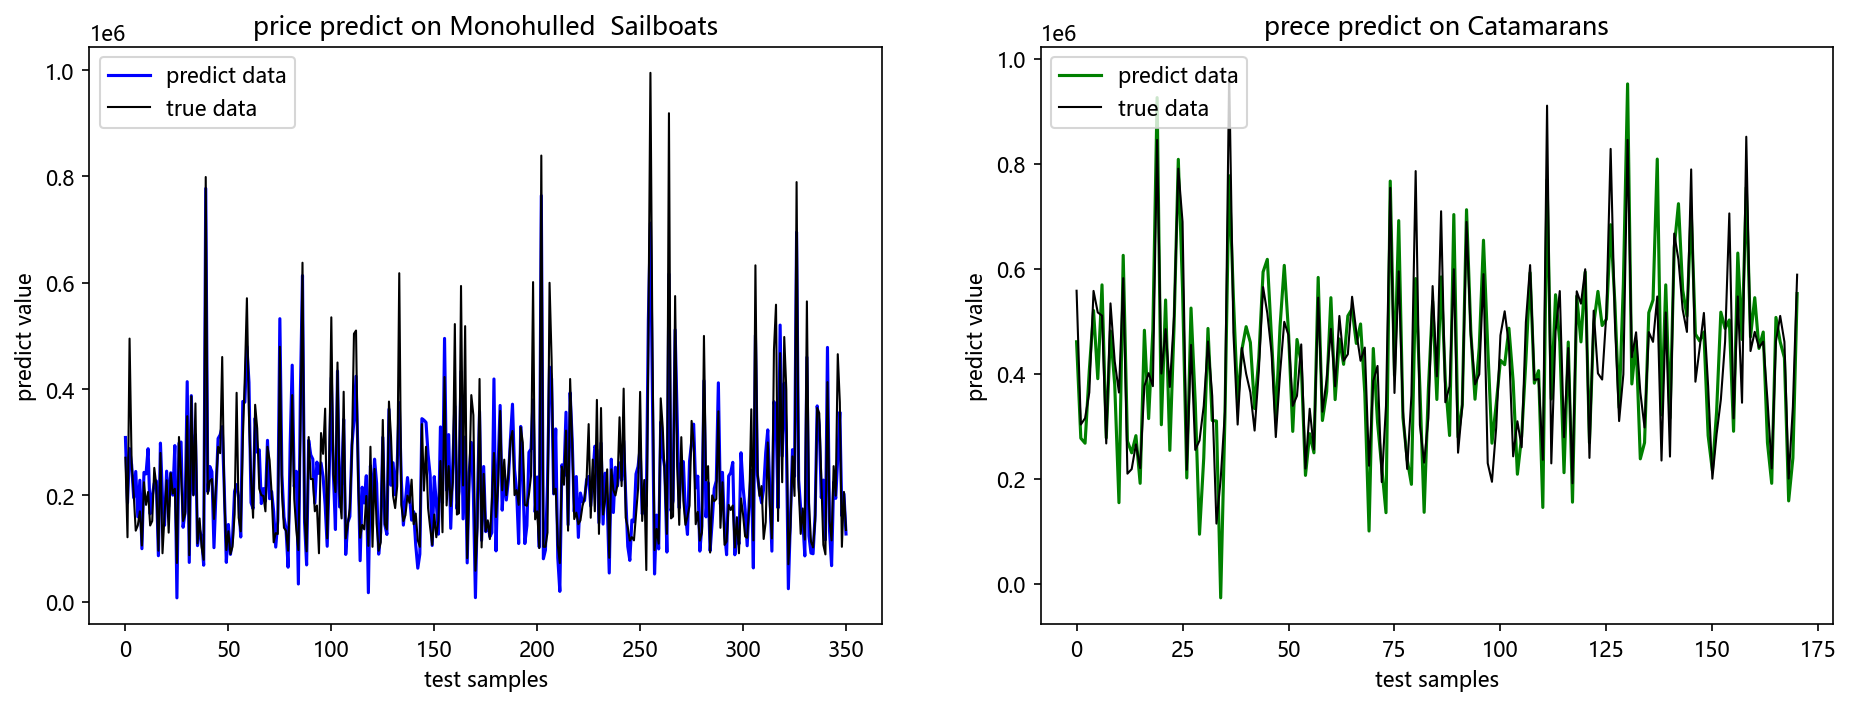

In [137]:
model_linear_M = LinearRegression()  ##为单帆数据构造线性回归模型
model_linear_C = LinearRegression()  ##为双帆数据构造线性回归模型
model_linear_M.fit(X_M_train,y_M_train)  ##训练单帆数据
model_linear_C.fit(X_C_train,y_C_train)  ##训练双帆数据
# 使用交叉验证计算 R2 分数
scores_M = cross_val_score(model_linear_M, X_M_train, y_M_train, cv=5, scoring='r2')
scores_C = cross_val_score(model_linear_C,X_C_train,y_C_train,cv = 5,scoring='r2')
print('在单帆训练集上的r2为:{:5f}'.format(scores_M.mean()))
print('在双帆训练集上的r2为:{:5f}'.format(scores_C.mean()))
## 对测试集进行预测
predict_M = model_linear_M.predict(X_M_test)
predict_C = model_linear_C.predict(X_C_test)
r2_M = r2_score(predict_M,y_M_test)
r2_C = r2_score(predict_C,y_C_test)
print('在单帆测试集上的r2为:{:5f}'.format(r2_M))
print('在双帆测试集上的r2为:{:5f}'.format(r2_C))
## 将预测值转化为原始数据的范围
predict_m = predict_M*(y_m_max-y_m_min)+y_m_min
predict_c = predict_C*(y_c_max-y_c_min)+y_c_min
true_m = y_M_test*(y_m_max-y_m_min)+y_m_min
true_c= y_C_test*(y_c_max-y_c_min)+y_c_min
predict_true_plot(y_predict1=predict_m,y_true1=true_m,y_predict2=predict_c,y_true2=true_c,filepath='Images/多元线性回归预测',title1='price predict on Monohulled  Sailboats',title2='prece predict on Catamarans')

## XGboost回归预测
XGBoost（eXtreme Gradient Boosting）是一种基于树模型的机器学习算法，它在许多数据科学竞赛中获得了出色的表现。XGBoost采用的是梯度提升决策树（Gradient Boosting Decision Tree，简称GBDT）算法，它的数学原理主要可以分为两部分：梯度提升和决策树。

梯度提升是一种集成学习算法，通过将多个弱分类器（比如决策树）组合起来形成一个强分类器。这里的“弱”指的是分类器的准确率略高于随机猜测的水平，但比较有限。梯度提升算法通过反复迭代，在每一轮迭代中训练一个新的弱分类器来纠正前一轮中模型的误差。在每一轮迭代中，算法会计算出当前模型的预测结果与真实结果之间的误差，然后将这个误差作为训练下一个弱分类器的标签，这就是“梯度”所在的地方。

决策树是一种基于树形结构的分类器，它将数据分割成多个区域，并对每个区域分别预测结果。决策树的构建过程就是寻找最优的分割点来划分数据，以便让不同区域的数据尽可能纯净，即同一个区域内的数据都属于同一个类别。在GBDT算法中，决策树是作为弱分类器使用的，每一棵决策树都负责对数据进行一次粗略的分割，以尽可能降低整体误差。

在XGBoost算法中，每一轮迭代都会构建一棵决策树，然后将这棵决策树的预测结果与之前的模型预测结果相加，得到一个新的预测结果。每一轮迭代的目标是找到一棵新的决策树，使得整体误差下降最多。为了达到这个目标，XGBoost算法引入了一些新的技术，比如加权的损失函数、正则化项和剪枝等

在单帆训练集上的r2为:0.819088
在双帆训练集上的r2为:0.866170
在单帆测试集上的r2为:0.795539
在双帆测试集上的r2为:0.834187


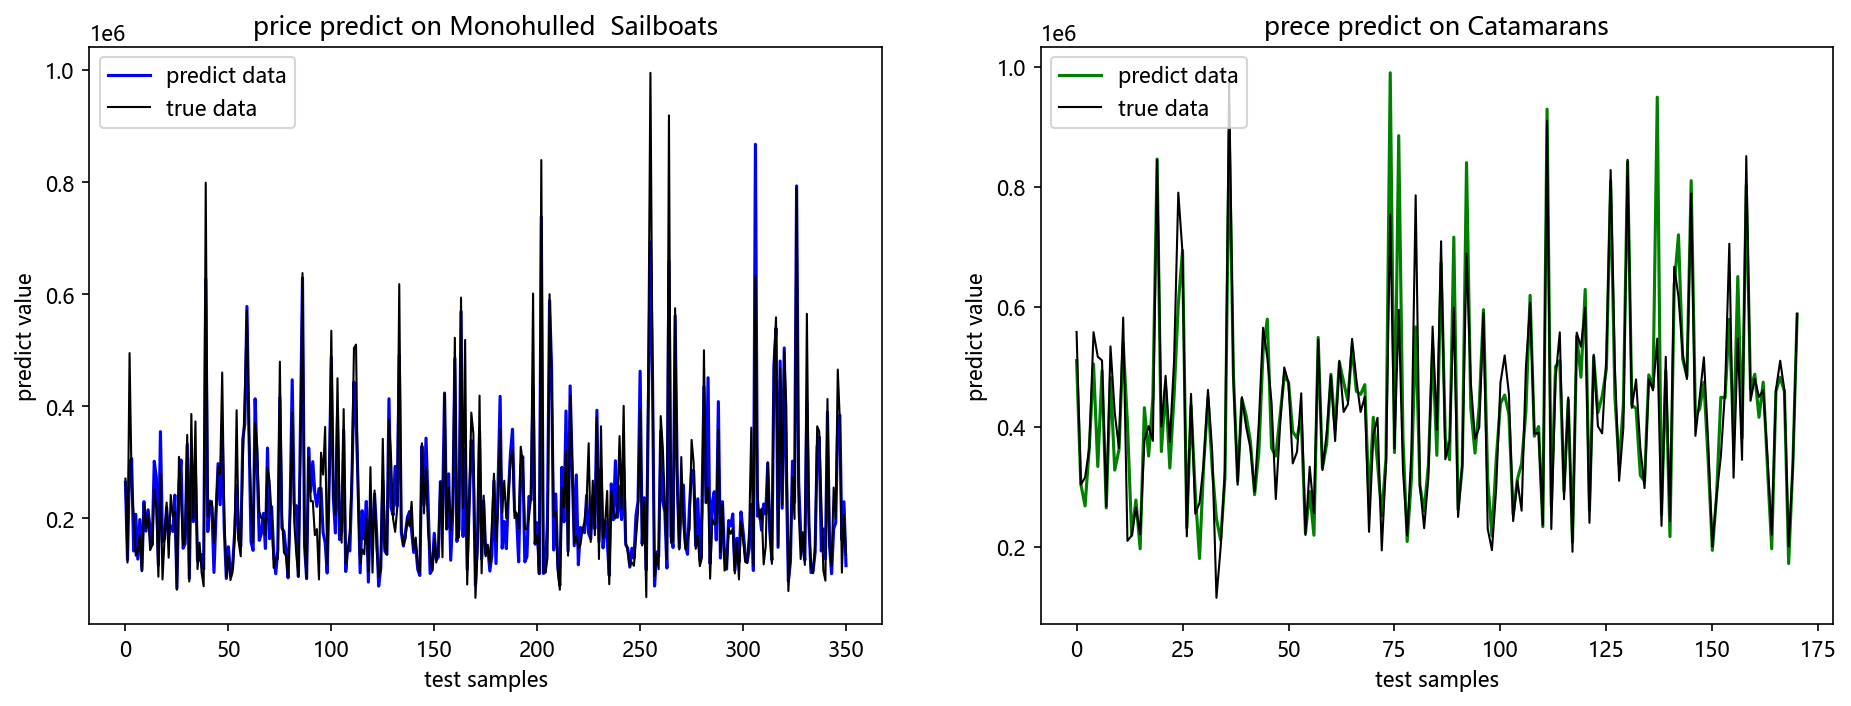

In [138]:
model_xgb_M  = XGBRegressor()
model_xgb_C = XGBRegressor()
model_xgb_M.fit(X_M_train,y_M_train)  ##训练单帆数据
model_xgb_C.fit(X_C_train,y_C_train)  ##训练双帆数据
# 使用交叉验证计算 R2 分数
scores_M = cross_val_score(model_xgb_M, X_M_train, y_M_train, cv=5, scoring='r2')
scores_C = cross_val_score(model_xgb_C,X_C_train,y_C_train,cv = 5,scoring='r2')
print('在单帆训练集上的r2为:{:5f}'.format(scores_M.mean()))
print('在双帆训练集上的r2为:{:5f}'.format(scores_C.mean()))
## 对测试集进行预测
predict_M = model_xgb_M.predict(X_M_test)
predict_C = model_xgb_C.predict(X_C_test)
r2_M = r2_score(predict_M,y_M_test)
r2_C = r2_score(predict_C,y_C_test)
print('在单帆测试集上的r2为:{:5f}'.format(r2_M))
print('在双帆测试集上的r2为:{:5f}'.format(r2_C))
## 将预测值转化为原始数据的范围
predict_m = predict_M*(y_m_max-y_m_min)+y_m_min
predict_c = predict_C*(y_c_max-y_c_min)+y_c_min
true_m = y_M_test*(y_m_max-y_m_min)+y_m_min
true_c= y_C_test*(y_c_max-y_c_min)+y_c_min
predict_true_plot(y_predict1=predict_m,y_true1=true_m,y_predict2=predict_c,y_true2=true_c,filepath='Images/XGboost回归预测',title1='price predict on Monohulled  Sailboats',title2='prece predict on Catamarans')

## 梯度提升树进行回归预测
梯度提升树（Gradient Boosting Tree，简称GBT）是一种基于决策树的集成学习算法，常用于回归和分类问题。其数学原理主要分为两部分：梯度提升和决策树。

梯度提升是一种迭代算法，每一次迭代通过训练一个新的模型来纠正前一次迭代的误差。在GBT中，每一次迭代都是训练一棵新的回归树，然后将其与之前的模型加权相加，得到一个新的模型。具体来说，对于给定的训练数据集，每次迭代都要拟合一个回归树模型，使得模型的输出与真实标签的差异最小化。训练完一棵回归树之后，将其与之前的模型加权相加，得到一个新的模型。这样不断迭代，最终得到一个集成的回归树模型。

决策树是一种树形结构的分类器，用于将数据划分为多个区域，并对每个区域进行预测。GBT中的每个弱分类器都是一棵回归树，其构建过程是通过将输入特征空间划分为多个区域，然后在每个区域内拟合一个常数值。GBT的每一棵树都是在前一棵树的残差基础上拟合的，所以可以看作是在不断降低模型的误差。

在GBT中，每一棵回归树的输出是一个常数值，因此最终模型的输出是多棵回归树输出的加权和。模型的损失函数通常为均方误差（MSE），即模型输出与真实标签之差的平方和，因此训练过程就是不断优化损失函数。为了避免过拟合，GBT中常常采用正则化技术，比如子采样和叶子节点数的限制等。

总之，GBT的主要思想是通过不断迭代训练多个回归树模型，并将其加权相加，来逐步提高整个模型的准确性

在单帆训练集上的r2为:0.763383
在双帆训练集上的r2为:0.844095
在单帆测试集上的r2为:0.592842
在双帆测试集上的r2为:0.811677


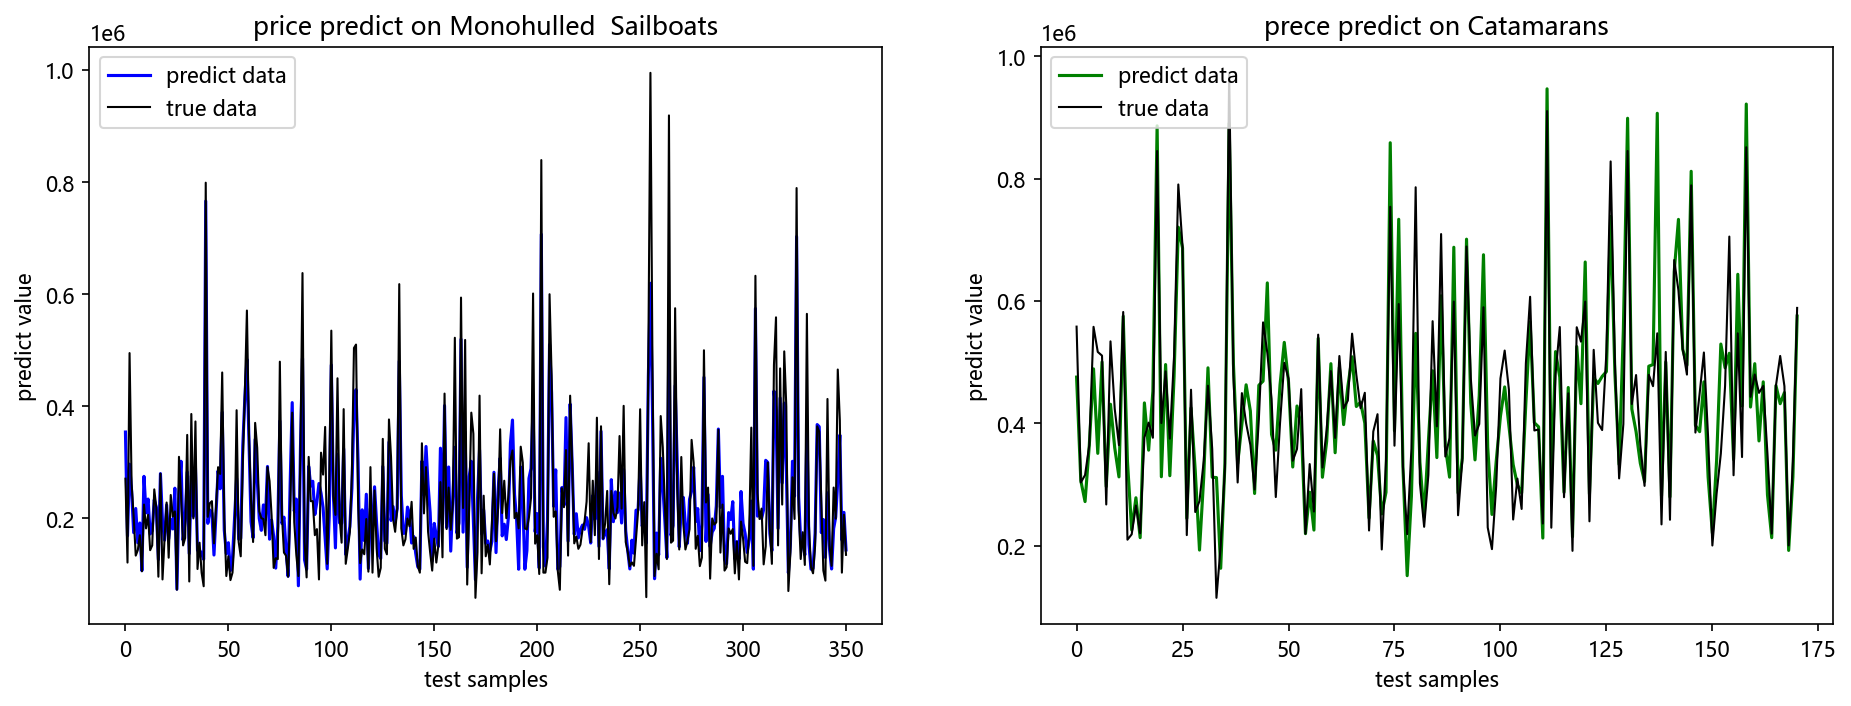

In [139]:
model_gbr_M = GradientBoostingRegressor()
model_gbr_C = GradientBoostingRegressor()
model_gbr_M.fit(X_M_train,y_M_train)  ##训练单帆数据
model_gbr_C.fit(X_C_train,y_C_train)  ##训练双帆数据
# 使用交叉验证计算 R2 分数
scores_M = cross_val_score(model_gbr_M, X_M_train, y_M_train, cv=5, scoring='r2')
scores_C = cross_val_score(model_gbr_C,X_C_train,y_C_train,cv = 5,scoring='r2')
print('在单帆训练集上的r2为:{:5f}'.format(scores_M.mean()))
print('在双帆训练集上的r2为:{:5f}'.format(scores_C.mean()))
## 对测试集进行预测
predict_M = model_gbr_M.predict(X_M_test)
predict_C = model_gbr_C.predict(X_C_test)
r2_M = r2_score(predict_M,y_M_test)
r2_C = r2_score(predict_C,y_C_test)
print('在单帆测试集上的r2为:{:5f}'.format(r2_M))
print('在双帆测试集上的r2为:{:5f}'.format(r2_C))
## 将预测值转化为原始数据的范围
predict_m = predict_M*(y_m_max-y_m_min)+y_m_min
predict_c = predict_C*(y_c_max-y_c_min)+y_c_min
true_m = y_M_test*(y_m_max-y_m_min)+y_m_min
true_c= y_C_test*(y_c_max-y_c_min)+y_c_min
predict_true_plot(y_predict1=predict_m,y_true1=true_m,y_predict2=predict_c,y_true2=true_c,filepath='Images/梯度提升树回归预测',title1='price predict on Monohulled  Sailboats',title2='prece predict on Catamarans')

在单帆训练集上的r2为:0.714898
在双帆训练集上的r2为:0.845304
在单帆测试集上的r2为:0.695161
在双帆测试集上的r2为:0.838300


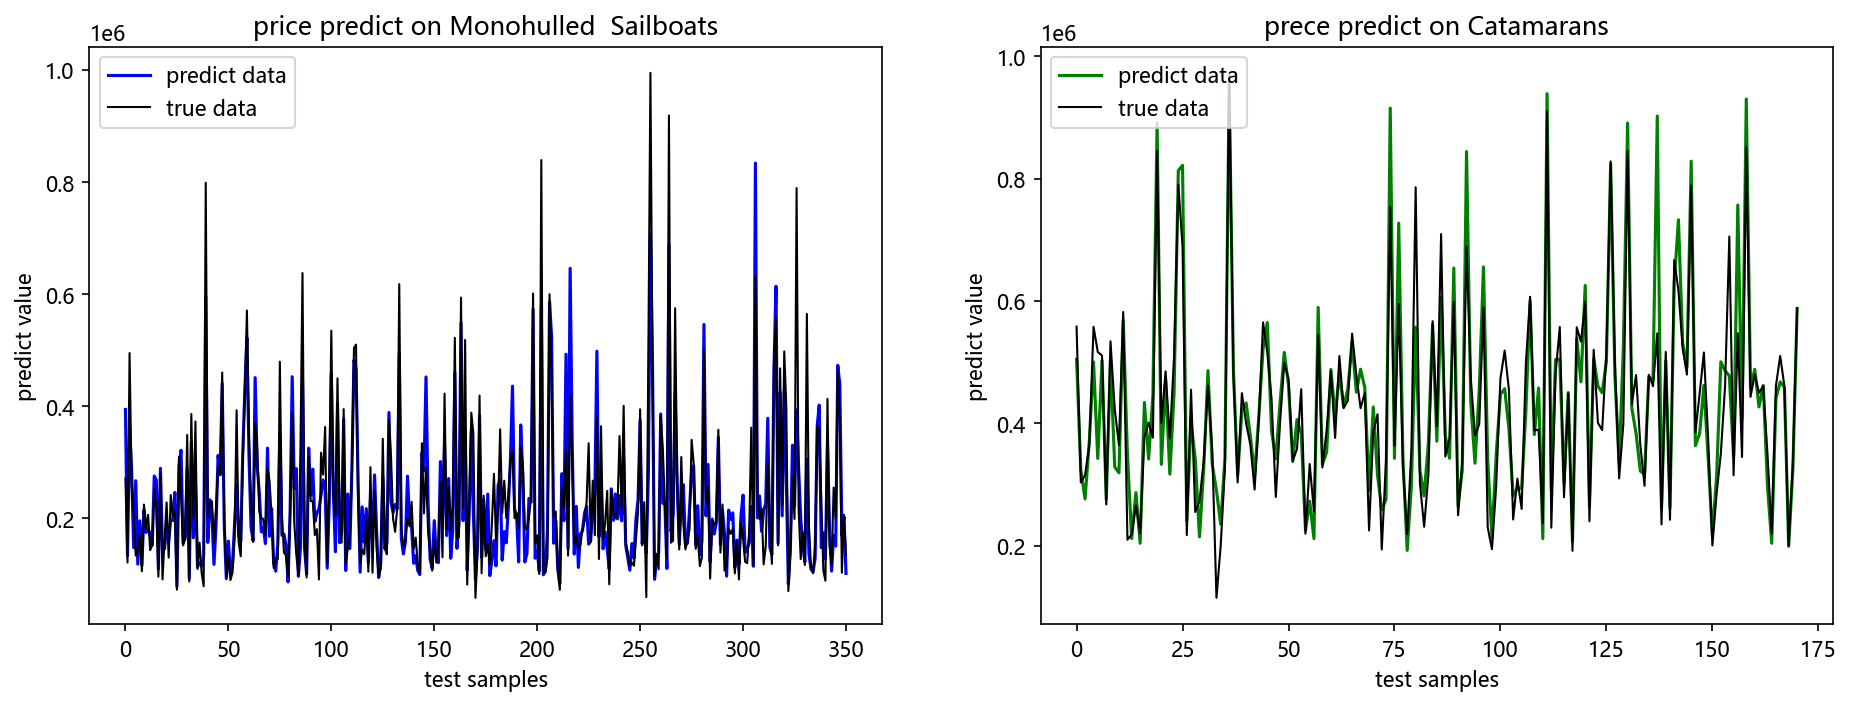

In [140]:
##  LightGBM进行回归预测
model_lgb_M = lgb.LGBMRegressor()
model_lgb_C = lgb.LGBMRegressor()
model_lgb_M.fit(X_M_train,y_M_train)  ##训练单帆数据
model_lgb_C.fit(X_C_train,y_C_train)  ##训练双帆数据
# 使用交叉验证计算 R2 分数
scores_M = cross_val_score(model_lgb_M, X_M_train, y_M_train, cv=5, scoring='r2')
scores_C = cross_val_score(model_lgb_C,X_C_train,y_C_train,cv = 5,scoring='r2')
print('在单帆训练集上的r2为:{:5f}'.format(scores_M.mean()))
print('在双帆训练集上的r2为:{:5f}'.format(scores_C.mean()))
## 对测试集进行预测
predict_M = model_lgb_M.predict(X_M_test)
predict_C = model_lgb_C.predict(X_C_test)
r2_M = r2_score(predict_M,y_M_test)
r2_C = r2_score(predict_C,y_C_test)
print('在单帆测试集上的r2为:{:5f}'.format(r2_M))
print('在双帆测试集上的r2为:{:5f}'.format(r2_C))
## 将预测值转化为原始数据的范围
predict_m = predict_M*(y_m_max-y_m_min)+y_m_min
predict_c = predict_C*(y_c_max-y_c_min)+y_c_min
true_m = y_M_test*(y_m_max-y_m_min)+y_m_min
true_c= y_C_test*(y_c_max-y_c_min)+y_c_min
predict_true_plot(y_predict1=predict_m,y_true1=true_m,y_predict2=predict_c,y_true2=true_c,filepath='Images/LightGBM回归预测',title1='price predict on Monohulled  Sailboats',title2='prece predict on Catamarans')

## 利用Skacking模型融合进行预测

在单帆训练集上的r2为:0.831889
在双帆训练集上的r2为:0.867221
在单帆测试集上的r2为:0.836496
在双帆测试集上的r2为:0.845197


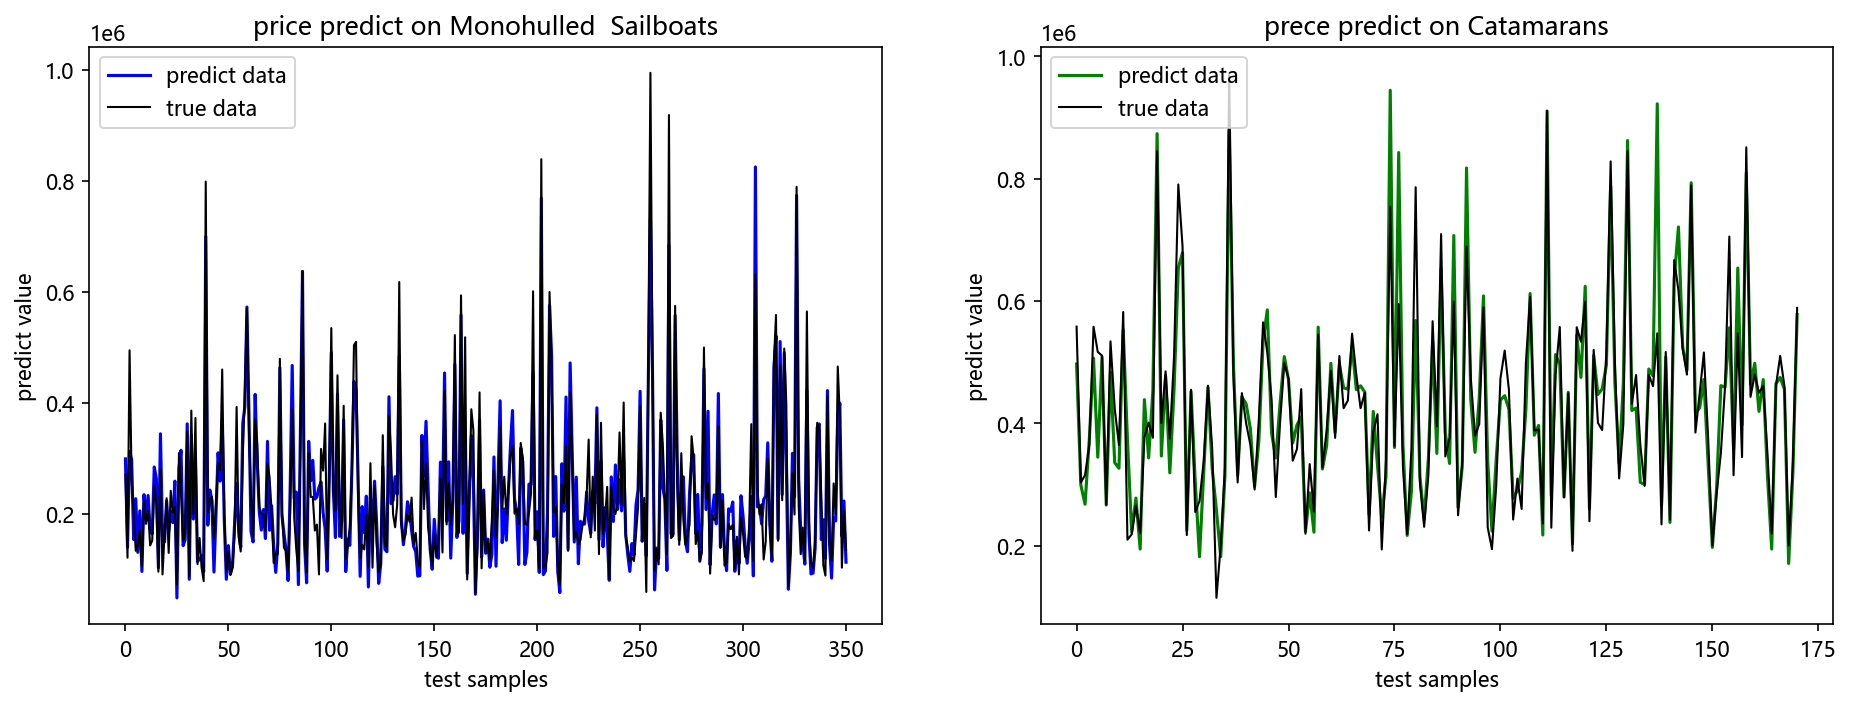

In [141]:
from sklearn.svm import SVR
base_regressors = [
                   ('lr', LinearRegression()),
                   ('xg',XGBRegressor()),
                   ('re',SVR()),
                   ('lgb',lgb.LGBMRegressor())
                   ]
meta_regressor = LinearRegression()
model_stack_M = StackingRegressor(estimators=base_regressors, final_estimator=meta_regressor)
model_stack_C = StackingRegressor(estimators=base_regressors, final_estimator=meta_regressor)
model_stack_M.fit(X_M_train,y_M_train)  ##训练单帆数据
model_stack_C.fit(X_C_train,y_C_train)  ##训练双帆数据
# 使用交叉验证计算 R2 分数
scores_M = cross_val_score(model_stack_M, X_M_train, y_M_train, cv=5, scoring='r2')
scores_C = cross_val_score(model_stack_C,X_C_train,y_C_train,cv = 5,scoring='r2')
print('在单帆训练集上的r2为:{:5f}'.format(scores_M.mean()))
print('在双帆训练集上的r2为:{:5f}'.format(scores_C.mean()))
## 对测试集进行预测
predict_M = model_stack_M.predict(X_M_test)
predict_C = model_stack_C.predict(X_C_test)
r2_M = r2_score(predict_M,y_M_test)
r2_C = r2_score(predict_C,y_C_test)
print('在单帆测试集上的r2为:{:5f}'.format(r2_M))
print('在双帆测试集上的r2为:{:5f}'.format(r2_C))
## 将预测值转化为原始数据的范围
predict_m = predict_M*(y_m_max-y_m_min)+y_m_min
predict_c = predict_C*(y_c_max-y_c_min)+y_c_min
true_m = y_M_test*(y_m_max-y_m_min)+y_m_min
true_c= y_C_test*(y_c_max-y_c_min)+y_c_min
predict_true_plot(y_predict1=predict_m,y_true1=true_m,y_predict2=predict_c,y_true2=true_c,filepath='Images/Stacking模型融合回归预测',title1='price predict on Monohulled  Sailboats',title2='prece predict on Catamarans')